# CA2 - Statistical Insights on Agriculture in Ireland and EU

## 1. Overview

In this notebook, the following agriculture datasets were analysed, focusing on Ireland and other similar countries in the EU:

- Organic Farming Area
- Crops and Livestock Products Import/Export
- Food Price Inflation

The datasets were studied and the following statistical techniques were applied:

- Confidence interval

- Hypoteshis tests:
    - Shapiro
    - Levene
    - Non-parametric tests:
        - Kruskal
        - Mannwhitneyu
        - Wilcoxon
    - Parametric test:
        - Anova One-Way

This notebook is divided into two parts (i) Confidence Interval and (ii) Hypothesis tests. 

In the first part, the Organic Farming Area dataset was used to find a confidence interval for the average area under organic farming in Europe.

In the second part, the Crops and Livestock Products Import/Export and the Food Price Inflation datasets were checked against some inferential statistics tests.

## 2. Auxiliary Functions

In this section, the auxiliary functions used in this notebook were implemented.

In [1]:
# adding modules folder to the path
import sys
sys.path.append('./modules')

# importing constants defined for this project
from constants import *

# importing modules specific to this notebook
# uncomment to install any missing lib
#!pip install altair
#!pip install pingouin
from IPython.display import Image
from pingouin import kruskal
from math import sqrt
from scipy.stats import wilcoxon
from scipy.stats import levene
from scipy import stats
from statsmodels.formula.api import ols
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

def is_dist_normal(data_col):
    """
    This function applies the Shapiro test to decide
    if the data is from a normal distribution or not.

    Parameters:
        data_col (data series): DataSeries
    Return:
        (bool): True if data is normal, false otherwise.
    """
    shapiro_test = stats.shapiro(data_col)
    if shapiro_test.pvalue > 0.05:
        return True
    return False
    
def plot_col_graph(data_col, title=''):
    """
    This function plots a graph for the column specified
    in the input.

    Parameters:
        data_col (data series): DataSeries
    """
    fig = plt.figure()
    ax = fig.add_subplot(111)
    stats.probplot(data_col, plot=ax)
    ax.set_title(title)

def get_non_empty_rows(col_data):
    """
    This function removes empty rows from data frame series (column).

    Parameters:
        col_data (pd.Series): DataFrame series
    Returns:
        Non empty rows
    """
    null_filter = col_data.notnull()
    return col_data[null_filter]

def conf_int_ts_student(mean, std, n, alpha=.97):
    """
    This function calculates the confidence interval for the given paramters.
    
    Parameters:
        mean (num): Average of the sample
        std  (num): Standard deviation of the sample
        n    (int): Size of sample
    Returns:
        (num, num): (lower limit, upper limit)
    """
    t = abs(stats.t.ppf((1 - alpha)/2, n - 1))
    interval = t * std/sqrt(n - 1)
    return mean - interval, mean + interval

def get_stats_array(stats_dict, val='mean'):
    """
    This function extracts the stats from the dictionary into a numpy array.
    
    Parameters:
        stats_dict (dict): Dictionary with custom statistics
        val         (str): Measurement to return (must be one of [mean, std, count, ll, ul])
    Returns:
        np array with values as per parameter or empty if input is invalid.
    """
    if val not in ['mean', 'std', 'count', 'll', 'ul']:
        return np.array([])
    return np.array(list([stats_dict[year][val] for year in stats_dict]))

## 3. Confidence Interval

For this study, the Organic Farming Area dataset from Eurostat portal were used.

In this analysis the sample data on the growth of organic farming in several European countries were used to obtain a confidence interval of the same growth in Europe (population) over the years.

The steps of this analysis were detailed in the section below.

### 3.1 Organic Farming Area

Eurostat provides yearly data on the percent of UAA (utilized agricultural area) under organic farming per country in Europe.

Problem: What is the average percent of land of the total UAA that is occupied by organic farming in Europe as a whole? How does it compare to Ireland?

- Available data:

    * Percent of total UAA under organic farming by year by country in Europe.

- Approach:

    * Use countries data (samples) to find a confidence interval for the total UAA under organic farming in Europe (population) per year. 

    * Compare the growth rate of organic farming in Europe with Ireland.

### 3.2 Data Preparation and Visualization

The data preparation steps on this dataset were implemented in Section 3 of the DataPrepVis Jupyter notebook.

Thus, the processed datasets were used directly in this notebook.

In [2]:
# getting organic farm dataset processed dataset
dataset = pd.read_csv(join(DATA_PREP_FOLDER, ORG_FARM_DATASET), encoding='utf-8')
dataset.head()

,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,3.0,NaN,3.8,4.0,NaN,3.8,4.1,4.0,4.3,4.7,...,5.4,5.66,5.70,5.78,6.20,6.68,7.03,7.50,7.92,9.08
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,5.88,5.91,6.08,6.56,7.09,7.48,8.03,8.49,9.08
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,5.64,5.70,5.78,6.20,6.68,7.03,7.50,7.92,NaN
3,1.5,1.6,2.1,1.7,1.7,1.7,2.1,2.4,2.6,3.0,...,4.1,4.48,4.67,5.00,5.17,5.80,6.28,6.56,6.85,7.25
4,NaN,NaN,NaN,NaN,NaN,0.2,0.1,0.3,0.3,0.2,...,0.5,0.76,1.13,0.96,2.37,3.20,2.72,2.56,2.34,2.30


In [3]:
# getting irish organic farm dataset processed dataset
dataset_ire = pd.read_csv(join(DATA_PREP_FOLDER, ORG_FARM_DATASET_IRE), encoding='utf-8')
dataset_ire.head()

,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,0.6,0.7,0.7,0.7,0.7,0.8,0.9,1,1,1.1,...,1.1,1.16,1.2,1.16,1.65,1.72,1.66,1.65,1.63,1.66


### 3.4 Analysis

For each year (column) it was calculated the standard deviation and average of the percent of land under organic farming in Europe based ont the countries in the dataset.

For each year, it was stored the standard deviation, mean, lower and upper limit obtained from the confidence interval calculation.

This way, it was possible to calculate the confidence interval of the population (Europe) per year.

In [5]:
# calculate descriptive stats (standard deviation and average) of the sample data - without nulls
stats_dict = {}
for c in dataset.keys():
    dataset_c = get_non_empty_rows(dataset[c])
    desc_stats = dataset_c.describe()
    stats_dict[c] = {'std': desc_stats.loc['std'],
                     'mean': desc_stats.loc['mean'],
                     'count': desc_stats.loc['count']}
    stats_dict[c]['ll'], stats_dict[c]['ul'] = conf_int_ts_student(stats_dict[c]['mean'], stats_dict[c]['std'],  stats_dict[c]['count'])

# displaying the results in a dataframe
pd.DataFrame(stats_dict)

,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
std,3.413662,3.561782,3.361703,3.365632,3.380808,3.563874,3.622215,3.588810,3.759333,4.106912,...,4.729839,4.459712,4.650973,4.784002,4.955867,5.288789,5.742230,5.992132,6.266459,6.480810
mean,3.505882,3.968750,4.188889,4.361905,4.111538,4.453333,4.648276,4.820690,5.151724,5.562069,...,6.278571,6.548788,6.115556,6.301111,6.514865,7.176111,7.404865,8.001667,8.225946,8.664286
count,17.000000,16.000000,18.000000,21.000000,26.000000,30.000000,29.000000,29.000000,29.000000,29.000000,...,28.000000,33.000000,36.000000,36.000000,37.000000,36.000000,37.000000,36.000000,37.000000,35.000000
ll,1.473435,1.764349,2.258136,2.603700,2.555603,2.943002,3.083170,3.270018,3.527372,3.787533,...,4.193249,4.758232,4.337119,4.471807,4.648544,5.153787,5.242409,5.710398,5.866071,6.146842
ul,5.538330,6.173151,6.119641,6.120109,5.667474,5.963664,6.213382,6.371361,6.776077,7.336605,...,8.363894,8.339344,7.893992,8.130415,8.381186,9.198436,9.567321,10.292935,10.585821,11.181729


### 3.5 Results

In this section, the results of the confidence interval obtained in the previous step were plotted into a graph.

This way, it's possible to observe how the size of organic farming has grown in Ireland as compared to Europe, using the confidence interval calculated from the sample data.

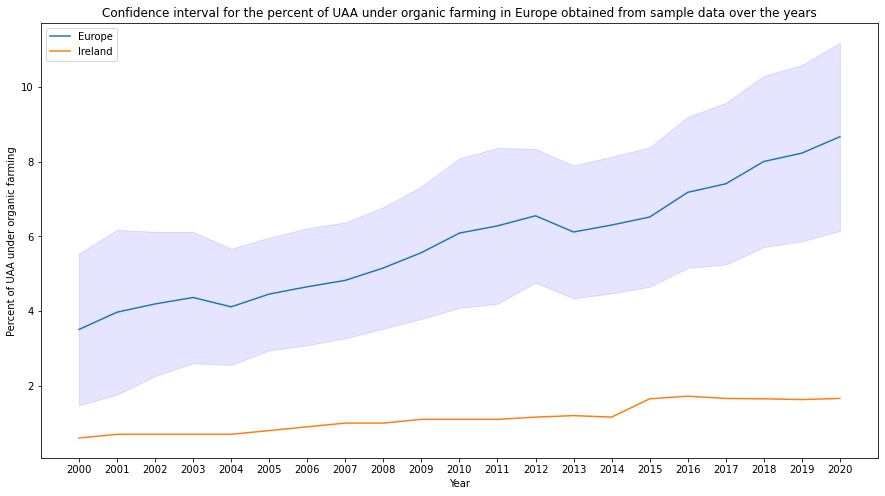

In [6]:
# get x data
x = np.array(list(stats_dict.keys()))

# get y data
y = get_stats_array(stats_dict, 'mean')

# get ll data
ll = get_stats_array(stats_dict, 'll')

# get ul data
ul = get_stats_array(stats_dict, 'ul')

# get ireland's data only
ire = dataset_ire.to_numpy().reshape(x.shape[0],)

# plot graph with europe and irelands data
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(x, y, label='Europe')
ax.set_title('Confidence interval for the percent of UAA under organic farming in Europe obtained from sample data over the years')
ax.set_xlabel('Year')
ax.set_ylabel('Percent of UAA under organic farming')
ax.fill_between(x, ll, ul, color='b', alpha=.1)
ax.plot(x, ire, label='Ireland')
plt.legend(loc=2)

# save graph into image
plt.savefig(join(IMAGES_FOLDER, GRAPH_CONF_INTERVAL), format='png')

Based on the confidence interval calculated it is possible to say with 97% confidence that in 2020, for instance, the percent of UAA under organic farming in Europe was between 6.14% and 11.18%.

This interval is accurate, because according to the <a href="https://agridata.ec.europa.eu/extensions/CountryFactsheets/CountryFactsheets.html?memberstate=Ireland#">Agridata</a>, in 2020, the percent of land under organic farming in Europe was about 9%.

## 4. Hypothesis Tests

In this section, two datasets were analyzed using hypotesis tests in order to compare their populations mean and variance.

Finland, Slovakia and Ireland have about the same population according to the <a href="https://worldpopulationreview.com/continents/europe-population">World Population Review website</a>, so for the scope of this project it was assumed they are similar countries.

### 4.1 Crops and Livestock Products Import/Export

FAO provides data on the import/export of crops and livestocks products from several countries with data ranging from 1961 up to 2020.

The main elements tracked are the import and export quantity, in tonnes, and value, in 1000 US$.

In this study, the data about the import and export of agricultural products from these countries were compared using inferential statistics tests.

#### 4.1.2 Data Preparation and Visualization

The data preparation steps on this dataset were implemented in Section 4 of the DataPrepVis Jupyter notebook.

Thus, the processed datasets were used directly in this notebook.

In [8]:
# getting import/export val processed dataset
im_ex_val_data = pd.read_csv(join(DATA_PREP_FOLDER, IMP_EXP_DATASET_VAL), encoding='utf-8')
im_ex_val_data.head()

,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code (CPC),Item,Year Code,Year,Unit,Value,Flag,Flag Description
0,TCL,Crops and livestock products,246,Finland,5622,Import Value,01929.07,"Abaca, manila hemp, raw",1961,1961,1000 US$,36.0,A,Official figure
1,TCL,Crops and livestock products,246,Finland,5622,Import Value,01929.07,"Abaca, manila hemp, raw",1962,1962,1000 US$,10.0,A,Official figure
2,TCL,Crops and livestock products,246,Finland,5622,Import Value,01929.07,"Abaca, manila hemp, raw",1963,1963,1000 US$,36.0,A,Official figure
3,TCL,Crops and livestock products,246,Finland,5622,Import Value,01929.07,"Abaca, manila hemp, raw",1964,1964,1000 US$,20.0,A,Official figure
4,TCL,Crops and livestock products,246,Finland,5622,Import Value,01929.07,"Abaca, manila hemp, raw",1965,1965,1000 US$,13.0,A,Official figure


In [9]:
# getting import/export quantity processed dataset
im_ex_qtt_data = pd.read_csv(join(DATA_PREP_FOLDER, IMP_EXP_DATASET_QTT), encoding='utf-8')
im_ex_qtt_data.head()

,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code (CPC),Item,Year Code,Year,Unit,Value,Flag,Flag Description
0,TCL,Crops and livestock products,246,Finland,5610,Import Quantity,01929.07,"Abaca, manila hemp, raw",1961,1961,tonnes,95.0,A,Official figure
1,TCL,Crops and livestock products,246,Finland,5610,Import Quantity,01929.07,"Abaca, manila hemp, raw",1962,1962,tonnes,32.0,A,Official figure
2,TCL,Crops and livestock products,246,Finland,5610,Import Quantity,01929.07,"Abaca, manila hemp, raw",1963,1963,tonnes,115.0,A,Official figure
3,TCL,Crops and livestock products,246,Finland,5610,Import Quantity,01929.07,"Abaca, manila hemp, raw",1964,1964,tonnes,49.0,A,Official figure
4,TCL,Crops and livestock products,246,Finland,5610,Import Quantity,01929.07,"Abaca, manila hemp, raw",1965,1965,tonnes,42.0,A,Official figure


As mentioned in the Section 4 of the DataPrepVis Jupyter notebook, Slovakia data covers a period of time between 1993 and 2020. 

Finland and Ireland have data starting from 1961, so this information was taken into account when comparing data between the countries.

The graph below shows the summarized (average) import/export quantities and values per country by year, respectivelly.

This way, it was possible to visualize the differences between the countries better, which helps to explain the results obtained by the inferential tests.

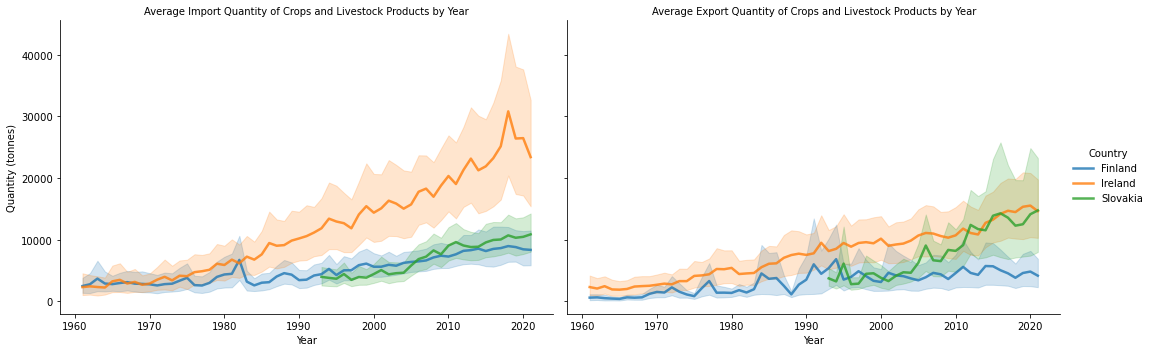

In [10]:
Image(filename=join(IMAGES_FOLDER, GRAPH_IMP_EXP_QTT))

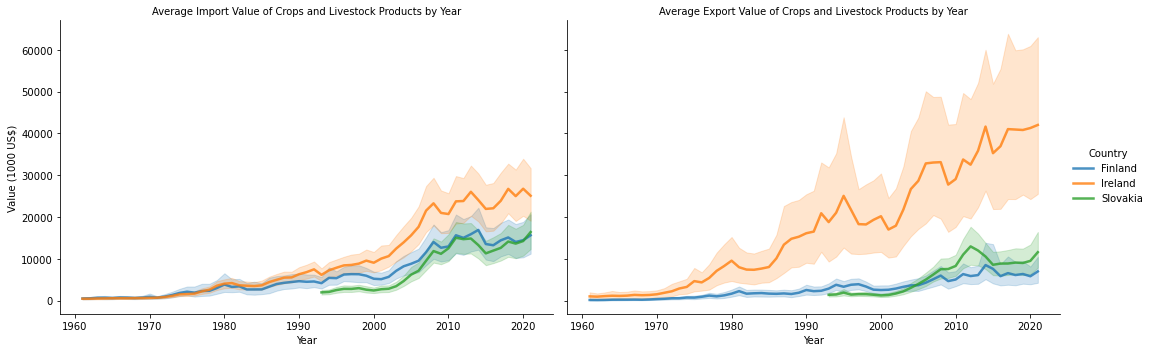

In [11]:
Image(filename=join(IMAGES_FOLDER, GRAPH_IMP_EXP_VAL))

According to the graphs, Ireland's import and export numbers are higher than the other countries, mainly in terms of export values in 1000 US$ (Graph 4).

Regarding Slovakia and Finland, they import about the same quantity and values, having slighlty different behaviour with regards to the export numbers, where Slovakia shows more exports than Finland.

#### 4.1.3 Analysis

In this section the import/export data from each country are compared using inferential statistics tests in order to validate if their trade are similar.

The summarized import/export data were calculated for all countries. Comparisons with Slovakia used data from 1993 until 2020 only due to Slovakia's lack of older data.

In [12]:
# getting the average quantity of tonnes of import/export a year
imp_ex_qtt_avg = im_ex_qtt_data.groupby(by=['Year', 'Element', 'Area'], as_index=False).mean().sort_values(by=['Year'], ignore_index=True)

# getting the average value in US$ of import/export a year
imp_ex_val_avg = im_ex_val_data.groupby(by=['Year', 'Element', 'Area'], as_index=False).mean().sort_values(by=['Year'], ignore_index=True)

##### Import/Export probability distributions - Shapiro Test

Firstly, it was checked if the import/export data were normally distributted in order to decide which inferential test to apply.

From the distribution plotted below it was observed the data was not normally distributed. Shapiro test was used to confirm that hypotesis.

Is Export Quantity from Finland normally distributed according to Shapiro Test? False
Is Import Quantity from Finland normally distributed according to Shapiro Test? False
Is Export Quantity from Ireland normally distributed according to Shapiro Test? False
Is Import Quantity from Ireland normally distributed according to Shapiro Test? False
Is Export Quantity from Slovakia normally distributed according to Shapiro Test? False
Is Import Quantity from Slovakia normally distributed according to Shapiro Test? False


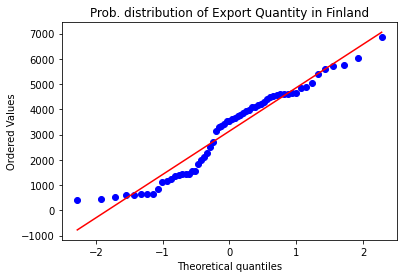

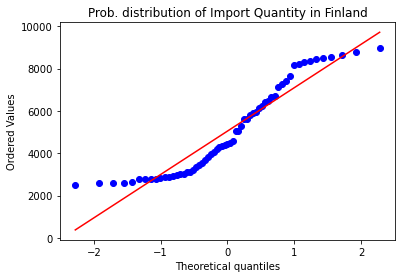

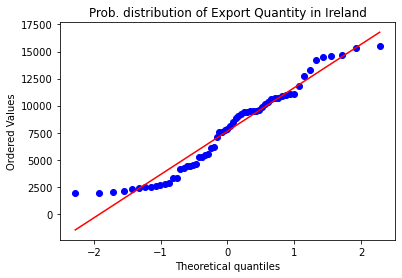

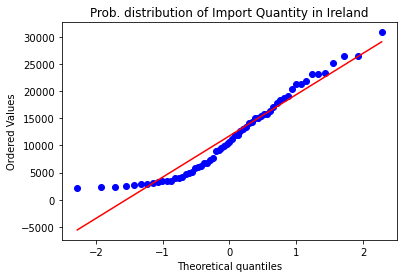

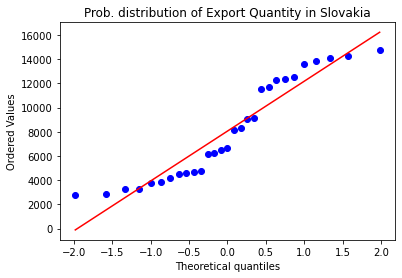

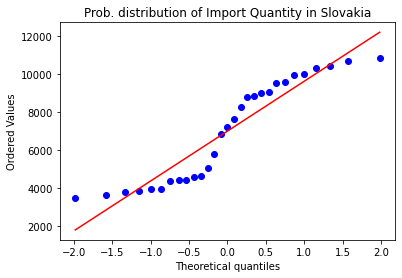

In [13]:
# checking import/export quantity average data are normal
for c in list(imp_ex_qtt_avg.Area.unique()):
    for e in list(imp_ex_qtt_avg.Element.unique()):
        data = imp_ex_qtt_avg[(imp_ex_qtt_avg['Area'] == c)&(imp_ex_qtt_avg['Element'] == e)].Value
        plot_col_graph(data, f'Prob. distribution of {e} in {c}')
        print(f'Is {e} from {c} normally distributed according to Shapiro Test? {is_dist_normal(data)}')

##### Import/Export between Slovakia and Finland - Kruskal Test

Since data was not normally distributed, Kruskal test was applied to check if populations of both Finland and Slovakia could be considered similar or not.

Since Slovakia data was tested, the date ranged from 1993 until 2020, so both datasets were aligned.

In [14]:
# compare Slovakia and Finland import quantity data
data = imp_ex_qtt_avg[(imp_ex_qtt_avg['Element'] == 'Import Quantity')&(imp_ex_qtt_avg['Area'].isin(['Slovakia', 'Finland']))&(imp_ex_qtt_avg['Year'] >= 1993)]
kruskal(data=data, dv='Value', between='Area')

,Source,ddof1,H,p-unc
Kruskal,Area,1,0.065842,0.79749


In [15]:
# compare Slovakia and Finland import value data
data = imp_ex_val_avg[(imp_ex_val_avg['Element'] == 'Import Value')&(imp_ex_val_avg['Area'].isin(['Slovakia', 'Finland']))&(imp_ex_val_avg['Year'] >= 1993)]
kruskal(data=data, dv='Value', between='Area')

,Source,ddof1,H,p-unc
Kruskal,Area,1,3.688647,0.054784


In [16]:
# compare Slovakia and Finland export quantity data
data = imp_ex_qtt_avg[(imp_ex_qtt_avg['Element'] == 'Export Quantity')&(imp_ex_qtt_avg['Area'].isin(['Slovakia', 'Finland']))&(imp_ex_qtt_avg['Year'] >= 1993)]
kruskal(data=data, dv='Value', between='Area')

,Source,ddof1,H,p-unc
Kruskal,Area,1,9.243294,0.002364


In [17]:
# compare Slovakia and Finland export value data
data = imp_ex_val_avg[(imp_ex_val_avg['Element'] == 'Export Value')&(imp_ex_val_avg['Area'].isin(['Slovakia', 'Finland']))&(imp_ex_val_avg['Year'] >= 1993)]
kruskal(data=data, dv='Value', between='Area')

,Source,ddof1,H,p-unc
Kruskal,Area,1,0.322195,0.570291


Based on the results from the Kruskal test and assuming 5% significance level, it was possible to conclude that, Finland and Slovakia are different regarding their export quantity.

However, both countries have similar average import value and quantity as well as export value of crops and livestock products.

This result can be verified by checking the graphs in the previous section, where it was observed that the curves for these countries are very close to each other.

##### Import/Export between Ireland and Finland - Kruskal Test

The same test was applied to compare Ireland and Finland.

In [18]:
# compare Ireland and Finland import quantity data
data = imp_ex_qtt_avg[(imp_ex_qtt_avg['Element'] == 'Import Quantity')&(imp_ex_qtt_avg['Area'].isin(['Ireland', 'Finland']))]
kruskal(data=data, dv='Value', between='Area')

,Source,ddof1,H,p-unc
Kruskal,Area,1,23.987579,9.695921e-07


In [19]:
# compare Ireland and Finland import value data
data = imp_ex_val_avg[(imp_ex_val_avg['Element'] == 'Import Value')&(imp_ex_val_avg['Area'].isin(['Ireland', 'Finland']))]
kruskal(data=data, dv='Value', between='Area')

,Source,ddof1,H,p-unc
Kruskal,Area,1,1.904294,0.167598


In [20]:
# compare Ireland and Finland export quantity data
data = imp_ex_qtt_avg[(imp_ex_qtt_avg['Element'] == 'Export Quantity')&(imp_ex_qtt_avg['Area'].isin(['Ireland', 'Finland']))]
kruskal(data=data, dv='Value', between='Area')

,Source,ddof1,H,p-unc
Kruskal,Area,1,37.975951,7.162206e-10


In [21]:
# compare Ireland and Finland export value data
data = imp_ex_val_avg[(imp_ex_val_avg['Element'] == 'Export Value')&(imp_ex_val_avg['Area'].isin(['Ireland', 'Finland']))]
kruskal(data=data, dv='Value', between='Area')

,Source,ddof1,H,p-unc
Kruskal,Area,1,41.65836,1.086996e-10


Based on the results from the Kruskal test and assuming 5% significance level, it was possible to conclude that Ireland and Finland are similar regarding their import values. 

However, there is evidence to say these two countries differ on their import quantity and export quantity and values average.

This result could be verified by checking the graphs in the previous section, where it was observed that these countries curves are distant from each other in most of the cases, expect for their import values.

##### Import/Export between Ireland and Finland - Mann-Whitneyu Test

In this section, it was used another non-parametric test to confirm results obtained with Kruskal. 

Validating the results when comparing Ireland and Finland trade data.

In [22]:
# getting only the necessary import data to apply the inferential test
im_value_ire = imp_ex_val_avg[(imp_ex_val_avg['Element'] == 'Import Value')&(imp_ex_val_avg['Area'] == 'Ireland')]
im_value_fin = imp_ex_val_avg[(imp_ex_val_avg['Element'] == 'Import Value')&(imp_ex_val_avg['Area'] == 'Finland')]
stats.mannwhitneyu(im_value_ire['Value'], im_value_fin['Value'])

MannwhitneyuResult(statistic=2130.0, pvalue=0.16838818790437227)

In [23]:
# getting only the necessary export data to apply the inferential test
im_value_ire = imp_ex_val_avg[(imp_ex_val_avg['Element'] == 'Export Value')&(imp_ex_val_avg['Area'] == 'Ireland')]
ex_value_ire = imp_ex_val_avg[(imp_ex_val_avg['Element'] == 'Export Value')&(imp_ex_val_avg['Area'] == 'Finland')]
stats.mannwhitneyu(im_value_ire['Value'], ex_value_ire['Value'])

MannwhitneyuResult(statistic=3121.0, pvalue=1.1055235070125434e-10)

The above results confirmed that, with 5% of significance level, Ireland and Finland were similar when it comes to their import value only, whereas in the other aspects there was enough evidence to confirm they had different trading average.

#### 4.1.4 Results

According to the tests above, Finland and Slovakia were similar countries with regards to import and export of agricultural products. They only differed in the quantity of goods that were exported from each country.

Ireland, on the other hand exported and imported much more than the other two countries, which could be confirmed by the inferential tests that showed the average of import/export between Ireland and Finland were substantially different.

### 4.2 Food price inflation

FAO provides data on the food price inflation from several countries with data from 2001 up to 2022.

In this study, the data about the food price inflation from these countries were compared using inferential statistics tests.

#### 4.2.1 Data Preparation and Visualization

The data preparation steps on this dataset were implemented in Section 5 of the DataPrepVis Jupyter notebook.

Thus, the processed datasets were used directly in this notebook.

In [24]:
# getting the food price inflation processed dataset
dataset = pd.read_csv(join(DATA_PREP_FOLDER, FOOD_INF_DATASET), encoding='utf-8')
dataset.head()

,Domain Code,Domain,Area Code (M49),Area,Year Code,Year,Item Code,Item,Months Code,Months,Unit,Value,Flag,Flag Description
0,CP,Consumer Price Indices,246,Finland,2001,2001,23014,Food price inflation,7001,January,%,3.900862,E,Estimated value
1,CP,Consumer Price Indices,246,Finland,2001,2001,23014,Food price inflation,7002,February,%,2.525304,E,Estimated value
2,CP,Consumer Price Indices,246,Finland,2001,2001,23014,Food price inflation,7003,March,%,2.998384,E,Estimated value
3,CP,Consumer Price Indices,246,Finland,2001,2001,23014,Food price inflation,7004,April,%,2.810568,E,Estimated value
4,CP,Consumer Price Indices,246,Finland,2001,2001,23014,Food price inflation,7005,May,%,4.679704,E,Estimated value


The graph below shows the summarized food price inflation per country by year. This way, it was possible to visualize the differences between the countries over the years.

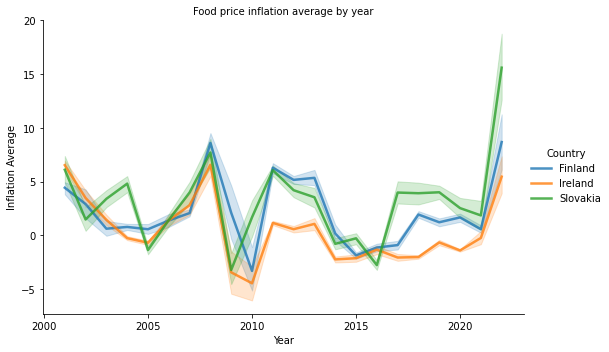

In [25]:
Image(filename=join(IMAGES_FOLDER, GRAPH_FOOD_PRICE_INF))

According to the graph, Slovakia presented the highest food inflation among the three countries, whereas Ireland had the lowest numbers.

#### 4.2.2 Analysis

In this section the food price inflation data from each country were compared using inferential statistics tests in order to validate if their average inflation could be considered similar.

The summarized inflation dataset was obtaind from the processed datasets folder.

In [26]:
# getting the summarized food price inflation processed dataset
food_inf_avg = pd.read_csv(join(DATA_PREP_FOLDER, FOOD_INF_DATASET_AVG), encoding='utf-8')
food_inf_avg.head()

,Year,Area,Area Code (M49),Year Code,Item Code,Months Code,Value
0,2001,Finland,246.0,2001.0,23014.0,7006.5,4.427115
1,2001,Ireland,372.0,2001.0,23014.0,7006.5,6.529999
2,2001,Slovakia,703.0,2001.0,23014.0,7006.5,6.102966
3,2002,Finland,246.0,2002.0,23014.0,7006.5,2.908811
4,2002,Ireland,372.0,2002.0,23014.0,7006.5,3.472100


##### Food price inflation probability distributions - Shapiro Test

Firstly, it was checked if the summarized inflation data were normally distributted in order to decide which inferential test to apply.

From the distribution plotted below it was observed the data was normally distributed for Finland and Ireland only. Shapiro test was used to confirm that hypotesis.

Is food price inflation from Finland normally distributed according to Shapiro Test? True
Is food price inflation from Ireland normally distributed according to Shapiro Test? True
Is food price inflation from Slovakia normally distributed according to Shapiro Test? False


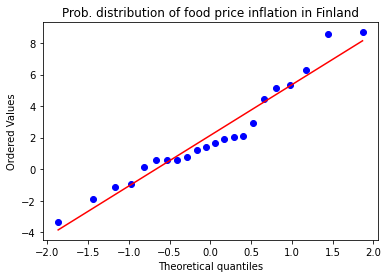

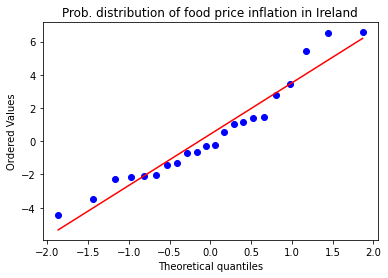

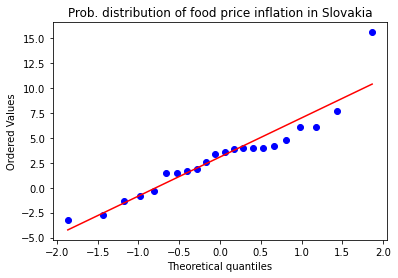

In [27]:
# checking food price inflation data are normal
for c in list(food_inf_avg.Area.unique()):
    data = food_inf_avg[food_inf_avg['Area'] == c].Value
    plot_col_graph(data, f'Prob. distribution of food price inflation in {c}')
    print(f'Is food price inflation from {c} normally distributed according to Shapiro Test? {is_dist_normal(data)}')

##### Food price inflation between Ireland and Finland - Wilcoxon Test

Using non-parametric test to compare the aggregated food price inflation between Ireland and Finland.

In [28]:
# use wilcoxon stats test to compare inflation between Ireland and Finland
wilcoxon(food_inf_avg[food_inf_avg['Area'] == 'Ireland'].Value, food_inf_avg[food_inf_avg['Area'] == 'Finland'].Value)

WilcoxonResult(statistic=31.0, pvalue=0.0010914802551269531)

The result above shows that, with 5% of significance level, the average food price inflation are not similar between Ireland and Finland.

##### Food price inflation between Slovakia and Finland - Wilcoxon Test

Using non-parametric test to compare the aggregated food price inflation between Slovakia and Finland.

In [29]:
# use wilcoxon stats test to compare inflation between Finland and Slovakia
wilcoxon(food_inf_avg[food_inf_avg['Area'] == 'Slovakia'].Value, food_inf_avg[food_inf_avg['Area'] == 'Finland'].Value)

WilcoxonResult(statistic=82.0, pvalue=0.15597057342529297)

The result above shows that, with 5% of significance level, the average food price inflation are similar between Slovakia and Finland.

##### Food price inflation between the countries - Levene Test

Using Levene test to check if the food price inflation data between Ireland and the other countries have the same variance.

In [30]:
# comparing data between Ireland and Slovakia
levene(dataset[dataset['Area'] == 'Ireland'].Value, dataset[dataset['Area'] == 'Slovakia'].Value, center='mean')

LeveneResult(statistic=8.514924067703584, pvalue=0.0036748959348910956)

In [31]:
# comparing data between Ireland and Finland
levene(dataset[dataset['Area'] == 'Ireland'].Value, dataset[dataset['Area'] == 'Finland'].Value, center='mean')

LeveneResult(statistic=1.4196957338379543, pvalue=0.23399702504417083)

In [32]:
# comparing data between Finland and Slovakia
levene(dataset[dataset['Area'] == 'Finland'].Value, dataset[dataset['Area'] == 'Slovakia'].Value, center='mean')

LeveneResult(statistic=3.3359605800846253, pvalue=0.06835399267412658)

The above results suggested that, with 5% of significance level, there is no significant difference in the variance of the average food price inflation between Ireland and Finland and Finland and Slovakia. 

However, this result also indicated that, with 5% of significance level, Ireland and Slovakia food price inflation variance were different. 

These results confirmed the first analysis of the graph in the Data Preparation and Visualization step.

##### Food price inflation between Finland and Ireland - Anova One Way Test

Using parametric test Anova with Ireland and Finland summarized food price inflation dataset as they met the normality requirement as per Shapiro test.

In [33]:
# using anova one way to compare Ireland and Finland
model = ols('Value~Area', data=food_inf_avg[food_inf_avg['Area'].isin(['Ireland', 'Finland'])]).fit()
aov = sm.stats.anova_lm(model, type=2)
print(aov)

            df      sum_sq    mean_sq         F    PR(>F)
Area       1.0   32.452641  32.452641  3.403211  0.072129
Residual  42.0  400.507295   9.535888       NaN       NaN


Based on the above result, with 5% of significance level, there is evidence to say that Ireland and Finland have similar food price inflation.

#### 4.2.3 Results

By using different parametric and non-parametric inferential statistics tests it was possible to confirm and validate the food price inflation differences between the countries.

Ireland and Finland have similar inflation, while Ireland and Slovakia have significant differences.